# ODE Examples
by AhmetSacan

**NOTE:** Initial Concentrations and reaction rates are hypothetical.

In [6]:
%load_ext autoreload
%autoreload 2
import sys,os; sys.path.append(os.environ['BMESAHMETDIR']); import bmes

import scipy
import numpy as np
import matplotlib.pyplot as plt
import math


from scipy.integrate import solve_ivp
def ode45(*args,**kargs):
	#if not 'method' in kargs: kargs['method']='RK45';
	sol=solve_ivp(*args,**kargs)
	return sol.t,sol.y

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Installing [python-libsbml] (importname=libsbml) using [pip] ...
Executing command: c:\ProgramData\Anaconda3\python.exe -m pip install -U python-libsbml
     ---------------------------------------- 5.7/5.7 MB 20.3 MB/s eta 0:00:00



## Irreversible Reaction: Burning Glucose

Reaction: sugar + 12oxygen -> 12carbondioxide + 11water Y: [sugar oxygen carbondioxide water]


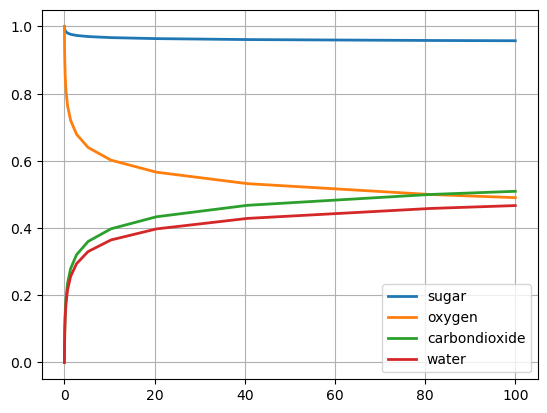

In [2]:
def diff_burningsugar(t,Y):
	#% Y: [sugar oxygen carbondioxide water]
	#% This is a hypothetical example. The reaction rate
	#% would not stay constant as we assume here. (Because temperature
	#% increases). "Accessibility" of a solid sugar is also a problematic
	#% assumption. We'll just ignore these problems and assume burning sugar
	#% follows a constant reaction rate.
	#% by AhmetSacan

	#% Reaction: sugar + 12oxygen -> 12carbondioxide + 11water
	#% Y: [sugar oxygen carbondioxide water]

	
	#%% unpack Y
	sugar,oxygen,co2,water = Y;

	kforward = 0.2; #%hypothetical value.

	#% reaction rate:
	v = kforward * sugar * oxygen**12;

	#% Reaction: sugar + 12oxygen -> 12carbondioxide + 11water
	dsugar = -v;
	doxygen = -12*v;
	#%For some species, assuming constant supply/concentration is more realistic.
	#%doxygen = 0;
	dco2 = 12*v;
	dwater = 11*v;

	#% pack derivatives into output variable
	dY = [dsugar, doxygen, dco2, dwater];
	return dY


#% hypothetical initial concentrations:
y0 = [1,1,0,0];
T,Y=ode45(diff_burningsugar, [0,100], y0);
plt.plot(T,Y[0,:], T,Y[1,:], T,Y[2,:], T,Y[3,:], linewidth=2);
plt.legend(['sugar', 'oxygen', 'carbondioxide', 'water']);
plt.grid('on')



## Importing and Simulating SBML models

In [12]:
# Chaudhury2020 - Lotka-Volterra mathematical model of CAR-T cell and tumour kinetics
#% See the model details at: https://www.ebi.ac.uk/biomodels/BIOMD0000001024
sbmlfile=bmes.downloadurl('https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL2108050001/4/Chaudhury2020%20Eq%204-5.xml','chaudhury20.lotkavolterra.cart.xml')

bmes.pipinstall('python-libsbml','libsbml')
import libsbml
doc = libsbml.SBMLReader().readSBML(sbmlfile)
mdl = doc.getModel()



## Model printing code adapted from: https://amici.readthedocs.io/en/latest/ExampleSteadystate.html
print("Species: ", [s.getId() for s in mdl.getListOfSpecies()])

print("\nReactions:")
for reaction in mdl.getListOfReactions():
    reactants = " + ".join(
        [
            "%s %s"
            % (
                int(r.getStoichiometry()) if r.getStoichiometry() > 1 else "",
                r.getSpecies(),
            )
            for r in reaction.getListOfReactants()
        ]
    )
    products = " + ".join(
        [
            "%s %s"
            % (
                int(r.getStoichiometry()) if r.getStoichiometry() > 1 else "",
                r.getSpecies(),
            )
            for r in reaction.getListOfProducts()
        ]
    )
    reversible = "<" if reaction.getReversible() else ""
    print(
        "%3s: %10s %1s->%10s\t\t[%s]"
        % (
            reaction.getId(),
            reactants,
            reversible,
            products,
            libsbml.formulaToL3String(reaction.getKineticLaw().getMath()),
        )
    )

Species:  ['Expanding_CAR_T_cells', 'Tumor_cells']

Reactions:
Expanding_CAR_T_cell_proliferation:             -> Expanding_CAR_T_cells		[Whole_organism_blood * Rate_Law_for_Expanding_CAR_T_cell_proliferation(rho, Expanding_CAR_T_cells, Tumor_cells)]
Expanding_CAR_T_cell_death:  Expanding_CAR_T_cells  ->          		[Whole_organism_blood * k_E * Expanding_CAR_T_cells]
Tumor_cell_growth:             -> Tumor_cells		[Whole_organism_blood * Rate_Law_for_Tumor_cell_growth(g, Tumor_cells)]
Tumor_cell_death:  Tumor_cells  ->          		[Whole_organism_blood * Rate_Law_for_Tumor_cell_death(d, Expanding_CAR_T_cells, Tumor_cells)]


libsbml only provides SBML model import/export and model management functions, but does not provide integration/simulation. You need to use other packages to simulate an SBML model within Python. Here are some options:
* [[https://amici.readthedocs.io/en/latest/about.html|AMICI]]
* [[https://libroadrunner.readthedocs.io/en/latest/|libRoadRunner]]
* [[https://github.com/libsbmlsim/libsbmlsim|libsmlsim]]